In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('base_cleaned_data.csv')

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_num = df[num_cols].copy()

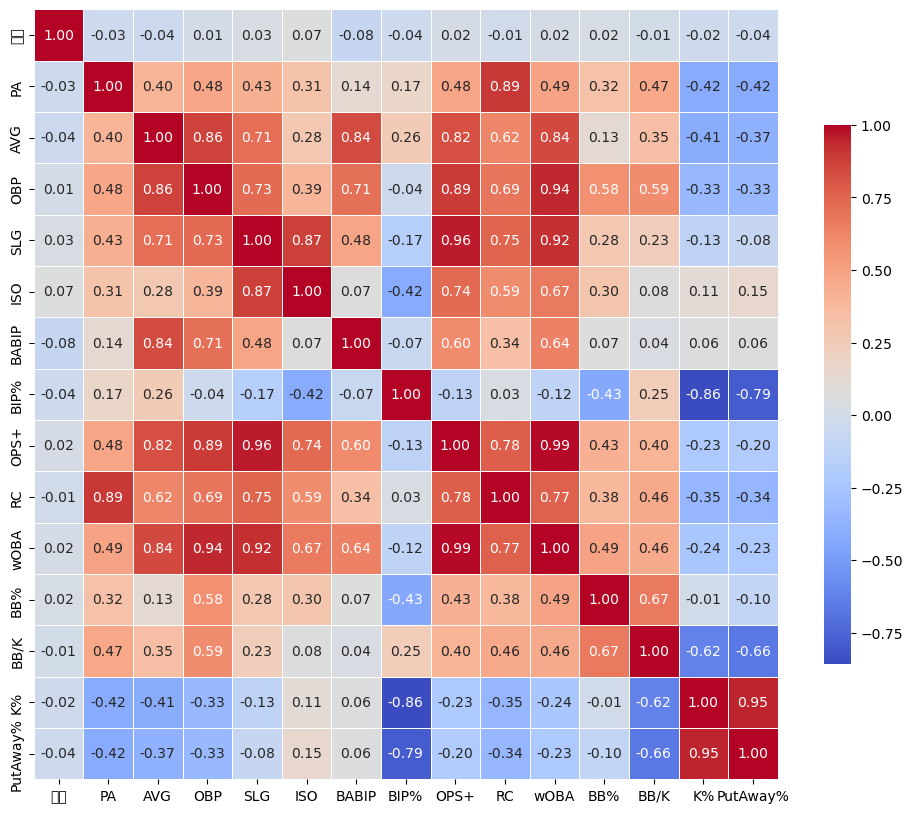

In [6]:
# show correlation heatmap
corr = df_num[num_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    ax=ax
)
plt.show()

In [7]:
# drop cols not needed, duplicated and variables used to produce target
df_model = df_num.drop(columns=['背號', 'OBP', 'SLG', 'wOBA', 'RC', 'ISO'])

In [8]:
# split data
X = df_model.drop(columns=['OPS+'])
y = df_model['OPS+']

In [9]:
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

Ridge()

In [13]:
y_pred = model.predict(X_test_scaled)

In [14]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [15]:
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

In [16]:
print("=" * 60)
print("Ridge Regression Model Results")
print("=" * 60)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Cross-Validation R² (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("=" * 60)

Ridge Regression Model Results
R² Score: 0.9716
RMSE: 5.9192
MAE: 4.4971
Cross-Validation R² (5-fold): 0.9468 (+/- 0.0058)


In [17]:
feature_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
feature_coef = feature_coef.sort_values('Coefficient', key=abs, ascending=False)
print("\nFeature Coefficients:")
print(feature_coef.to_string(index=False))


Feature Coefficients:
 Feature  Coefficient
     AVG    40.097194
    BIP%   -25.005764
   BABIP   -16.512182
      K%    -9.156232
     BB%    -2.001053
      PA     1.754816
    BB/K    -0.560858
PutAway%    -0.128871


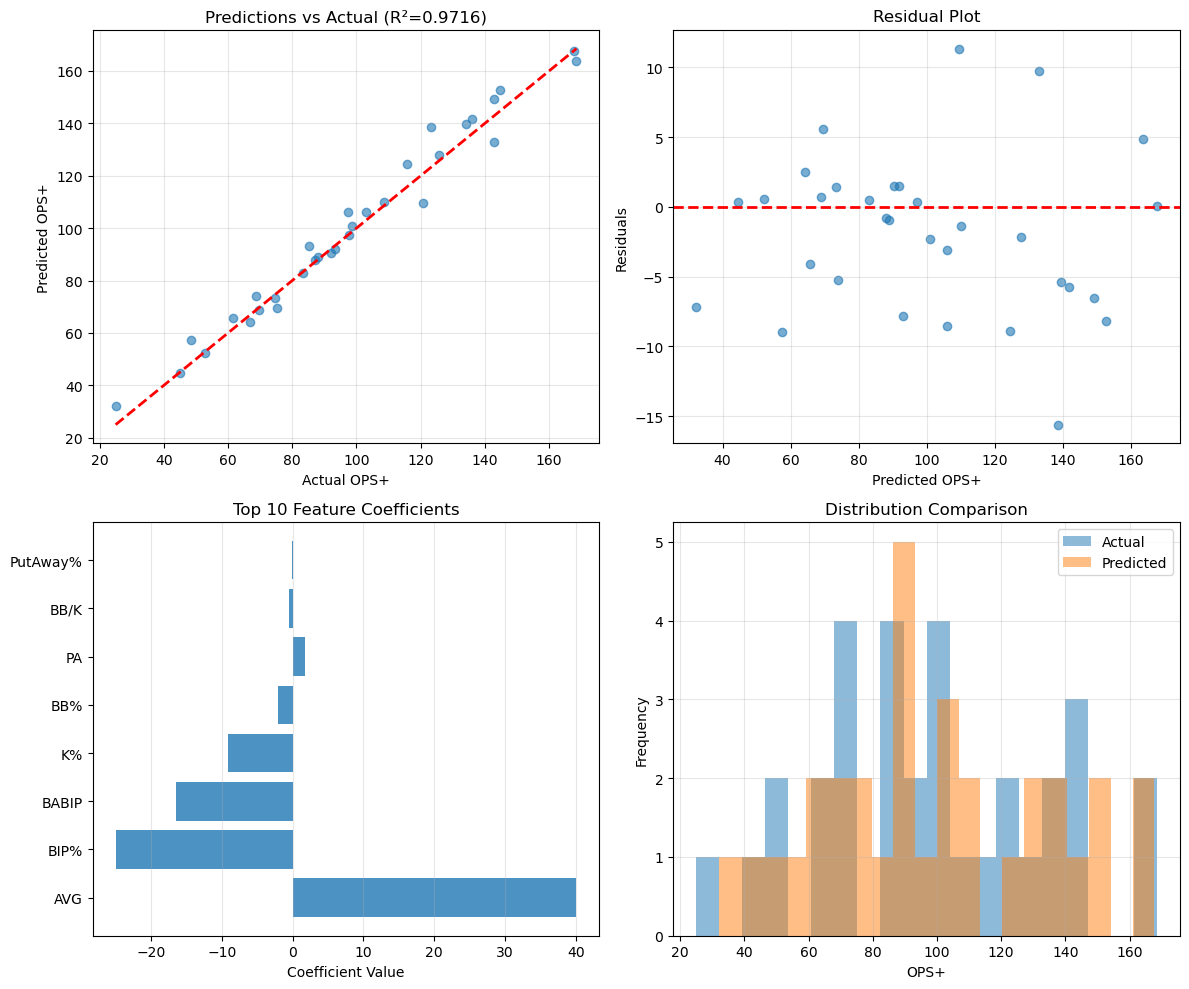

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# predictions vs actual
axs[0, 0].scatter(y_test, y_pred, alpha=0.6)
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axs[0, 0].set_xlabel('Actual OPS+')
axs[0, 0].set_ylabel('Predicted OPS+')
axs[0, 0].set_title(f'Predictions vs Actual (R²={r2:.4f})')
axs[0, 0].grid(alpha=0.3)

# residual plot
residuals = y_test - y_pred
axs[0, 1].scatter(y_pred, residuals, alpha=0.6)
axs[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axs[0, 1].set_xlabel('Predicted OPS+')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].set_title('Residual Plot')
axs[0, 1].grid(alpha=0.3)

# feature importance (coefficients)
top_features = feature_coef.head(10)
axs[1, 0].barh(range(len(top_features)), top_features['Coefficient'], alpha=0.8)
axs[1, 0].set_yticks(range(len(top_features)))
axs[1, 0].set_yticklabels(top_features['Feature'])
axs[1, 0].set_xlabel('Coefficient Value')
axs[1, 0].set_title('Top 10 Feature Coefficients')
axs[1, 0].grid(axis='x', alpha=0.3)

# actual vs predicted distribution
axs[1, 1].hist(y_test, bins=20, alpha=0.5, label='Actual')
axs[1, 1].hist(y_pred, bins=20, alpha=0.5, label='Predicted')
axs[1, 1].set_xlabel('OPS+')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution Comparison')
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
prediction_results = pd.DataFrame({
    'Actual_OPS+': y_test.values,
    'Predicted_OPS+': y_pred,
    'Residual': y_test.values - y_pred
})
prediction_results.head(10)

,Actual_OPS+,Predicted_OPS+,Residual
0,74.7,73.249694,1.450306
1,52.7,52.160605,0.539395
2,66.8,64.279849,2.520151
3,69.6,68.913027,0.686973
4,103.0,106.089936,-3.089936
5,85.2,93.046500,-7.846500
6,97.6,97.258949,0.341051
7,134.2,139.614526,-5.414526
8,83.4,82.921564,0.478436
9,87.2,87.977993,-0.777993
